In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as sql
import requests
import json
from bs4 import BeautifulSoup

In [2]:
#Create SQLite database and fill it with our cleaned datasets (cleaning steps replicated below)
conn = sql.connect('covid.db')
cursor = conn.cursor()

In [3]:
#Import flat file data
covidData = pd.read_excel("Cases_by_County_and_Date_2020-10-10_704800_7.xlsx")
covidData.head()

,COUNTY,Date,CASE_STATUS,Cases,Deaths,Cases.Cumulative,Deaths.Cumulative,Updated
0,Alcona,2020-03-01,Confirmed,0,0,0,0,2020-10-10 14:21:15.249
1,Alcona,2020-03-02,Confirmed,0,0,0,0,2020-10-10 14:21:15.249
2,Alcona,2020-03-03,Confirmed,0,0,0,0,2020-10-10 14:21:15.249
3,Alcona,2020-03-04,Confirmed,0,0,0,0,2020-10-10 14:21:15.249
4,Alcona,2020-03-05,Confirmed,0,0,0,0,2020-10-10 14:21:15.249


In [4]:
#Data prep step 1 - replace all string fields with lower case versions of their current elements, strip any white space
covidData['COUNTY'] = covidData['COUNTY'].str.strip()
covidData['COUNTY'] = covidData['COUNTY'].str.lower()
covidData['CASE_STATUS'] = covidData['CASE_STATUS'].str.lower()
covidData['CASE_STATUS'] = covidData['CASE_STATUS'].str.strip()
covidData.head()

,COUNTY,Date,CASE_STATUS,Cases,Deaths,Cases.Cumulative,Deaths.Cumulative,Updated
0,alcona,2020-03-01,confirmed,0,0,0,0,2020-10-10 14:21:15.249
1,alcona,2020-03-02,confirmed,0,0,0,0,2020-10-10 14:21:15.249
2,alcona,2020-03-03,confirmed,0,0,0,0,2020-10-10 14:21:15.249
3,alcona,2020-03-04,confirmed,0,0,0,0,2020-10-10 14:21:15.249
4,alcona,2020-03-05,confirmed,0,0,0,0,2020-10-10 14:21:15.249


In [5]:
#Data prep step 2 - Filter for only Wayne county
covidData = covidData[covidData['COUNTY'] == 'wayne']
covidData.head()

,COUNTY,Date,CASE_STATUS,Cases,Deaths,Cases.Cumulative,Deaths.Cumulative,Updated
19264,wayne,2020-03-01,confirmed,4,0,4,0,2020-10-10 14:21:15.249
19265,wayne,2020-03-02,confirmed,3,0,7,0,2020-10-10 14:21:15.249
19266,wayne,2020-03-03,confirmed,0,0,7,0,2020-10-10 14:21:15.249
19267,wayne,2020-03-04,confirmed,2,0,9,0,2020-10-10 14:21:15.249
19268,wayne,2020-03-05,confirmed,4,0,13,0,2020-10-10 14:21:15.249


In [6]:
#Data prep step 3 - Drop fields that are not relevant to the study
covidData = covidData.drop(['Updated'], axis = 1)
covidData.head()

,COUNTY,Date,CASE_STATUS,Cases,Deaths,Cases.Cumulative,Deaths.Cumulative
19264,wayne,2020-03-01,confirmed,4,0,4,0
19265,wayne,2020-03-02,confirmed,3,0,7,0
19266,wayne,2020-03-03,confirmed,0,0,7,0
19267,wayne,2020-03-04,confirmed,2,0,9,0
19268,wayne,2020-03-05,confirmed,4,0,13,0


In [7]:
#Data prep step 4 - Identify any null or missing values and eliminate them if necessary
covidData.shape

(448, 7)

In [8]:
covidData.dropna()
covidData.shape

(448, 7)

In [9]:
#The row count staying the same after dropping all null and NaN values shows that the dataset has no missing or null values 

In [10]:
#Data prep step 5 - Remove original index, reset for a new index that is unique to the wayne county data, and adjust headers
covidData = covidData.reset_index().drop(columns=['index'])
covidData.head()

,COUNTY,Date,CASE_STATUS,Cases,Deaths,Cases.Cumulative,Deaths.Cumulative
0,wayne,2020-03-01,confirmed,4,0,4,0
1,wayne,2020-03-02,confirmed,3,0,7,0
2,wayne,2020-03-03,confirmed,0,0,7,0
3,wayne,2020-03-04,confirmed,2,0,9,0
4,wayne,2020-03-05,confirmed,4,0,13,0


In [11]:
covidData.rename(columns={'COUNTY': 'County', 'CASE_STATUS': 'Case_Status', 'Cases.Cumulative': 'Total_Cases', 'Deaths.Cumulative': 'Total_Deaths'})

,County,Date,Case_Status,Cases,Deaths,Total_Cases,Total_Deaths
0,wayne,2020-03-01,confirmed,4,0,4,0
1,wayne,2020-03-02,confirmed,3,0,7,0
2,wayne,2020-03-03,confirmed,0,0,7,0
3,wayne,2020-03-04,confirmed,2,0,9,0
4,wayne,2020-03-05,confirmed,4,0,13,0
...,...,...,...,...,...,...,...
443,wayne,2020-10-06,probable,27,0,1556,50
444,wayne,2020-10-07,probable,24,0,1580,50
445,wayne,2020-10-08,probable,19,0,1599,50
446,wayne,2020-10-09,probable,9,0,1608,50


In [12]:
covidData.to_sql("countyData", con=conn)

In [13]:
apiData = requests.get("https://api.covidtracking.com/v1/us/daily.json")

In [14]:
stringData = json.loads(apiData.text)
covid = pd.DataFrame(stringData)
covid.head()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,lastModified,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
0,20201121,56,11927256,143010617,17683.0,83227.0,540906.0,16054.0,28693.0,5103.0,...,177614398,2020-11-21T24:00:00Z,0,0,1506,3241,1426550,178309,1977400,cf675a8bdc6204a364c0fe4779d944ae529c617d
1,20201120,56,11748947,141584067,16203.0,82178.0,537665.0,15915.0,28472.0,5055.0,...,175636998,2020-11-20T24:00:00Z,0,0,1862,3821,1389882,192805,1917476,1755138f25e62191fd46512c77544d6789785cc4
2,20201119,56,11556142,140194185,14604.0,80698.0,533844.0,15573.0,28216.0,4859.0,...,173719522,2020-11-19T24:00:00Z,0,0,1971,4676,1286632,182832,1817525,6378e5b1f0bf0e4a2f8d358d96cb67f8c27de6e0
3,20201118,56,11373310,138907553,12971.0,79410.0,529168.0,15350.0,27989.0,4701.0,...,171901997,2020-11-18T24:00:00Z,0,0,1869,4490,1074463,163975,1534573,5dc1b316e5e7b6ecaff11b00041cf335793ee775
4,20201117,56,11209335,137833090,9281.0,76958.0,524678.0,14851.0,27681.0,4379.0,...,170367424,2020-11-17T24:00:00Z,0,0,1555,3915,1092462,156722,1503534,4b92f29fcf980dedba895d88f44d26ea816be797


In [15]:
#Step 1: Remove Hash field
covid.drop('hash', axis = 1, inplace=True)

In [16]:
#step 2: Fill missing values from pending field
#step 3: Convert pending from float to int
for col in covid.columns:
    try:
        covid[col] = covid[col].fillna(0.0).astype(int)
    except:
        print("Not a column that can be converted to an int")

Not a column that can be converted to an int
Not a column that can be converted to an int


In [17]:
type(covid['pending'][0])

numpy.int32

In [18]:
covid.head()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,totalTestResults,lastModified,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20201121,56,11927256,143010617,17683,83227,540906,16054,28693,5103,...,540906,177614398,2020-11-21T24:00:00Z,0,0,1506,3241,1426550,178309,1977400
1,20201120,56,11748947,141584067,16203,82178,537665,15915,28472,5055,...,537665,175636998,2020-11-20T24:00:00Z,0,0,1862,3821,1389882,192805,1917476
2,20201119,56,11556142,140194185,14604,80698,533844,15573,28216,4859,...,533844,173719522,2020-11-19T24:00:00Z,0,0,1971,4676,1286632,182832,1817525
3,20201118,56,11373310,138907553,12971,79410,529168,15350,27989,4701,...,529168,171901997,2020-11-18T24:00:00Z,0,0,1869,4490,1074463,163975,1534573
4,20201117,56,11209335,137833090,9281,76958,524678,14851,27681,4379,...,524678,170367424,2020-11-17T24:00:00Z,0,0,1555,3915,1092462,156722,1503534


In [19]:
#step 4: format date
covid['date'] = pd.to_datetime(covid['date'], format='%Y%m%d')
covid.head()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,totalTestResults,lastModified,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-11-21,56,11927256,143010617,17683,83227,540906,16054,28693,5103,...,540906,177614398,2020-11-21T24:00:00Z,0,0,1506,3241,1426550,178309,1977400
1,2020-11-20,56,11748947,141584067,16203,82178,537665,15915,28472,5055,...,537665,175636998,2020-11-20T24:00:00Z,0,0,1862,3821,1389882,192805,1917476
2,2020-11-19,56,11556142,140194185,14604,80698,533844,15573,28216,4859,...,533844,173719522,2020-11-19T24:00:00Z,0,0,1971,4676,1286632,182832,1817525
3,2020-11-18,56,11373310,138907553,12971,79410,529168,15350,27989,4701,...,529168,171901997,2020-11-18T24:00:00Z,0,0,1869,4490,1074463,163975,1534573
4,2020-11-17,56,11209335,137833090,9281,76958,524678,14851,27681,4379,...,524678,170367424,2020-11-17T24:00:00Z,0,0,1555,3915,1092462,156722,1503534


In [20]:
#Step 5: Find how many NaN or null values exist and then remove them if they exist
nullList = covid.isnull().sum(axis=1)
for row in nullList:
    print(row)
#There are no null values in the dataframe 

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [21]:
covid.to_sql('CountryData', con = conn)

In [22]:
#I have added the unemployment data for the entire country as well. As I will be looking to add more data from other
#high population areas in the US
r = requests.get("https://www.bls.gov/opub/ted/2020/unemployment-rate-16-point-1-percent-in-massachusetts-4-point-5-percent-in-utah-in-july-2020.htm#:~:text=U.S.%20unemployment%20rate%3A%2010.2%25%20in%20July%202020")
r.text

'\n\n\n\n<!DOCTYPE HTML>\n<html lang="en-us">\t\n\t\r\n<head>\r\n<!-- P1 -->\r\n\n\t                                <title>Unemployment rate 16.1 percent in Massachusetts, 4.5 percent in Utah, in July 2020 : The Economics Daily: U.S. Bureau of Labor Statistics</title>\n\t\t\t\t\t\t\t<meta charset="UTF-8">\n\t\t\n\t\t\n\t\t\t\t\t<meta name="description" content="Massachusetts had the highest unemployment rate in July 2020, 16.1 percent, followed by New York, 15.9 percent. Nevada, New Jersey, Pennsylvania, California, and Hawaii also had unemployment rates above 13.0 percent in July. The rates in Connecticut (10.2 percent), New Mexico (12.7 percent), and New York (15.9 percent) set new series highs. (State unemployment data begin in 1976.)" />\n\t\t\n\t\t\t\t\n\n\t\t\t\t\t\t\t\t<meta name="date" content="2020-08-27" />\n\t\t\t\t\n\t\t\t\t\t\t\n\t\t                        \t\t\t\t<meta name="keywords" content="" />\n\t\t\t\t\n\t\t    \t\t\t\t\t<meta name="surveys" content="" />\n\t\t\t\t\

In [23]:
soup = BeautifulSoup(r.text)
#Find the table
data = soup.find("table", {"class":"regular"})
print(data)

<table class="regular" id="BLStable_2020_8_24_15_31" style="width: 95%;"><caption><span class="tableTitle">Unemployment rates by state, January 2020–July 2020</span></caption>
<thead>
<tr>
<th rowspan="1" scope="col" style="vertical-align: middle; min-width: 80px;">State</th>
<th scope="col">Jan 2020</th>
<th scope="col">Feb 2020</th>
<th scope="col">Mar 2020</th>
<th scope="col">Apr 2020</th>
<th scope="col">May 2020</th>
<th scope="col">Jun 2020</th>
<th scope="col">Jul 2020</th>
</tr>
</thead>
<tbody>
<tr>
<th scope="row">
<p>Massachusetts</p>
</th>
<td>2.8%</td>
<td>2.8%</td>
<td>2.8%</td>
<td>16.2%</td>
<td>16.6%</td>
<td>17.7%</td>
<td>16.1%</td>
</tr>
<tr class="greenbar">
<th scope="row">
<p>New York</p>
</th>
<td>3.8</td>
<td>3.7</td>
<td>4.1</td>
<td>15.3</td>
<td>14.5</td>
<td>15.6</td>
<td>15.9</td>
</tr>
<tr>
<th scope="row">
<p>Nevada</p>
</th>
<td>3.6</td>
<td>3.6</td>
<td>6.9</td>
<td>30.1</td>
<td>25.3</td>
<td>15.2</td>
<td>14.0</td>
</tr>
<tr class="greenbar">
<th sc

In [27]:
source = data.tbody.find_all('tr',recursive=False)[0]
sourceList = [td for td in source.find_all('td')]
print(len(sourceList))

#Get tables
dataTable = data.tbody.find_all('tr', recursive=False)[1].find_all('td', recursive=False)
dataTableList = []
for td in dataTable:
    dataTableList.append(td.find_all('table'))
print(len(dataTableList))
print(dataTableList)

#Get header names
headers = []
for tx in data.find_all('th'):
    headers.append(tx.getText().strip())
print(headers)

7
7
[[], [], [], [], [], [], []]
['State', 'Jan 2020', 'Feb 2020', 'Mar 2020', 'Apr 2020', 'May 2020', 'Jun 2020', 'Jul 2020', 'Massachusetts', 'New York', 'Nevada', 'New Jersey', 'Pennsylvania', 'California', 'Hawaii', 'New Mexico', 'Alaska', 'Florida', 'Illinois', 'Rhode Island', 'Mississippi', 'Arizona', 'Delaware', 'Oregon', 'Washington', 'Connecticut', 'Maine', 'West Virginia', 'Tennessee', 'Louisiana', 'Ohio', 'Michigan', 'South Carolina', 'North Carolina', 'District of Columbia', 'Vermont', 'New Hampshire', 'Texas', 'Virginia', 'Alabama', 'Indiana', 'Minnesota', 'Georgia', 'Maryland', 'Colorado', 'Kansas', 'Arkansas', 'Oklahoma', 'Wyoming', 'Wisconsin', 'Missouri', 'Iowa', 'North Dakota', 'Montana', 'South Dakota', 'Kentucky', 'Idaho', 'Nebraska', 'Utah']


In [28]:
rows = data.find_all('tbody')[0].find_all('tr')[1:]
data_rows = [[td.getText().strip() for td in tr.find_all('td')] for tr in rows] 
states = [[td.getText().strip() for td in tr.find_all('th')] for tr in rows]
len(data_rows)

50

In [29]:
#Create dictionary of states and unemployment values, 8
dataDict = {}
count = 0
for header in headers[9:]:
    dataDict[header] = data_rows[count]
    count += 1
dataDict


{'New York': ['3.8', '3.7', '4.1', '15.3', '14.5', '15.6', '15.9'],
 'Nevada': ['3.6', '3.6', '6.9', '30.1', '25.3', '15.2', '14.0'],
 'New Jersey': ['3.8', '3.8', '3.7', '16.3', '15.4', '16.8', '13.8'],
 'Pennsylvania': ['4.7', '4.7', '5.8', '16.1', '13.4', '13.2', '13.7'],
 'California': ['3.9', '3.9', '5.5', '16.4', '16.4', '14.9', '13.3'],
 'Hawaii': ['2.7', '2.7', '2.4', '23.8', '23.5', '13.4', '13.1'],
 'New Mexico': ['4.8', '4.8', '6.3', '11.9', '9.1', '8.4', '12.7'],
 'Alaska': ['6.0', '5.8', '5.2', '13.5', '12.7', '12.4', '11.6'],
 'Florida': ['2.8', '2.8', '4.4', '13.8', '13.7', '10.3', '11.3'],
 'Illinois': ['3.5', '3.4', '4.2', '17.2', '15.3', '14.5', '11.3'],
 'Rhode Island': ['3.4', '3.4', '4.7', '18.1', '16.4', '12.6', '11.2'],
 'Mississippi': ['5.5', '5.4', '5.1', '16.3', '10.5', '8.8', '10.8'],
 'Arizona': ['4.5', '4.5', '6.1', '13.4', '9.0', '10.0', '10.6'],
 'Delaware': ['4.0', '3.9', '5.0', '14.9', '15.9', '12.6', '10.4'],
 'Oregon': ['3.3', '3.3', '3.5', '14.9', '1

In [30]:
#Transform #1: Put data into a more readable format
tableDf = pd.DataFrame.from_dict(dataDict)
tableDf.head()

,New York,Nevada,New Jersey,Pennsylvania,California,Hawaii,New Mexico,Alaska,Florida,Illinois,...,Wisconsin,Missouri,Iowa,North Dakota,Montana,South Dakota,Kentucky,Idaho,Nebraska,Utah
0,3.8,3.6,3.8,4.7,3.9,2.7,4.8,6.0,2.8,3.5,...,3.5,3.5,2.8,2.3,3.5,3.4,4.3,2.8,2.9,2.5
1,3.7,3.6,3.8,4.7,3.9,2.7,4.8,5.8,2.8,3.4,...,3.5,3.5,2.8,2.2,3.5,3.3,4.2,2.7,2.9,2.5
2,4.1,6.9,3.7,5.8,5.5,2.4,6.3,5.2,4.4,4.2,...,3.1,3.9,3.3,2.0,3.6,3.1,5.2,2.5,4.0,3.8
3,15.3,30.1,16.3,16.1,16.4,23.8,11.9,13.5,13.8,17.2,...,13.6,10.2,11.0,9.1,11.9,10.9,16.6,11.8,8.7,10.4
4,14.5,25.3,15.4,13.4,16.4,23.5,9.1,12.7,13.7,15.3,...,12.1,10.1,10.2,9.1,9.0,9.4,10.9,9.0,5.3,8.6


In [31]:
#Transform #2 : Replaced headers and made them the states
tableDf['Month'] = headers[1:8]
tableDf.head()

,New York,Nevada,New Jersey,Pennsylvania,California,Hawaii,New Mexico,Alaska,Florida,Illinois,...,Missouri,Iowa,North Dakota,Montana,South Dakota,Kentucky,Idaho,Nebraska,Utah,Month
0,3.8,3.6,3.8,4.7,3.9,2.7,4.8,6.0,2.8,3.5,...,3.5,2.8,2.3,3.5,3.4,4.3,2.8,2.9,2.5,Jan 2020
1,3.7,3.6,3.8,4.7,3.9,2.7,4.8,5.8,2.8,3.4,...,3.5,2.8,2.2,3.5,3.3,4.2,2.7,2.9,2.5,Feb 2020
2,4.1,6.9,3.7,5.8,5.5,2.4,6.3,5.2,4.4,4.2,...,3.9,3.3,2.0,3.6,3.1,5.2,2.5,4.0,3.8,Mar 2020
3,15.3,30.1,16.3,16.1,16.4,23.8,11.9,13.5,13.8,17.2,...,10.2,11.0,9.1,11.9,10.9,16.6,11.8,8.7,10.4,Apr 2020
4,14.5,25.3,15.4,13.4,16.4,23.5,9.1,12.7,13.7,15.3,...,10.1,10.2,9.1,9.0,9.4,10.9,9.0,5.3,8.6,May 2020


In [32]:
#Transform #3: Remove the year values from the Month column
tableDf['Month'] = tableDf['Month'].str[0:3]
tableDf.head()

,New York,Nevada,New Jersey,Pennsylvania,California,Hawaii,New Mexico,Alaska,Florida,Illinois,...,Missouri,Iowa,North Dakota,Montana,South Dakota,Kentucky,Idaho,Nebraska,Utah,Month
0,3.8,3.6,3.8,4.7,3.9,2.7,4.8,6.0,2.8,3.5,...,3.5,2.8,2.3,3.5,3.4,4.3,2.8,2.9,2.5,Jan
1,3.7,3.6,3.8,4.7,3.9,2.7,4.8,5.8,2.8,3.4,...,3.5,2.8,2.2,3.5,3.3,4.2,2.7,2.9,2.5,Feb
2,4.1,6.9,3.7,5.8,5.5,2.4,6.3,5.2,4.4,4.2,...,3.9,3.3,2.0,3.6,3.1,5.2,2.5,4.0,3.8,Mar
3,15.3,30.1,16.3,16.1,16.4,23.8,11.9,13.5,13.8,17.2,...,10.2,11.0,9.1,11.9,10.9,16.6,11.8,8.7,10.4,Apr
4,14.5,25.3,15.4,13.4,16.4,23.5,9.1,12.7,13.7,15.3,...,10.1,10.2,9.1,9.0,9.4,10.9,9.0,5.3,8.6,May


In [33]:
#Transform #4 : Remove rows that are not needed for our study
tableDf = tableDf[2:]
tableDf.head()

,New York,Nevada,New Jersey,Pennsylvania,California,Hawaii,New Mexico,Alaska,Florida,Illinois,...,Missouri,Iowa,North Dakota,Montana,South Dakota,Kentucky,Idaho,Nebraska,Utah,Month
2,4.1,6.9,3.7,5.8,5.5,2.4,6.3,5.2,4.4,4.2,...,3.9,3.3,2.0,3.6,3.1,5.2,2.5,4.0,3.8,Mar
3,15.3,30.1,16.3,16.1,16.4,23.8,11.9,13.5,13.8,17.2,...,10.2,11.0,9.1,11.9,10.9,16.6,11.8,8.7,10.4,Apr
4,14.5,25.3,15.4,13.4,16.4,23.5,9.1,12.7,13.7,15.3,...,10.1,10.2,9.1,9.0,9.4,10.9,9.0,5.3,8.6,May
5,15.6,15.2,16.8,13.2,14.9,13.4,8.4,12.4,10.3,14.5,...,7.8,8.4,7.4,7.2,7.2,4.4,5.8,5.5,5.3,Jun
6,15.9,14.0,13.8,13.7,13.3,13.1,12.7,11.6,11.3,11.3,...,6.9,6.6,6.6,6.4,6.3,5.7,5.0,4.8,4.5,Jul


In [34]:
#Transform #5: Reorder columns such that the month column 
#is the first column/index
tableDf = tableDf.set_index('Month')
tableDf.head()

,New York,Nevada,New Jersey,Pennsylvania,California,Hawaii,New Mexico,Alaska,Florida,Illinois,...,Wisconsin,Missouri,Iowa,North Dakota,Montana,South Dakota,Kentucky,Idaho,Nebraska,Utah
Month,,,,,,,,,,,,,,,,,,,,,
Mar,4.1,6.9,3.7,5.8,5.5,2.4,6.3,5.2,4.4,4.2,...,3.1,3.9,3.3,2.0,3.6,3.1,5.2,2.5,4.0,3.8
Apr,15.3,30.1,16.3,16.1,16.4,23.8,11.9,13.5,13.8,17.2,...,13.6,10.2,11.0,9.1,11.9,10.9,16.6,11.8,8.7,10.4
May,14.5,25.3,15.4,13.4,16.4,23.5,9.1,12.7,13.7,15.3,...,12.1,10.1,10.2,9.1,9.0,9.4,10.9,9.0,5.3,8.6
Jun,15.6,15.2,16.8,13.2,14.9,13.4,8.4,12.4,10.3,14.5,...,8.6,7.8,8.4,7.4,7.2,7.2,4.4,5.8,5.5,5.3
Jul,15.9,14.0,13.8,13.7,13.3,13.1,12.7,11.6,11.3,11.3,...,7.0,6.9,6.6,6.6,6.4,6.3,5.7,5.0,4.8,4.5


In [35]:
tableDf.to_sql('unemployment', con=conn)

G:\Anaconda\lib\site-packages\pandas\core\generic.py:2653: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [36]:
#Now all cleaned tables have been added to the in-memory sqlite database

In [37]:
#Visualizations

In [38]:
#This data will have to be joined differently from the other two datasets
miEmploymentData = pd.read_sql_query("SELECT Month, Michigan FROM unemployment", conn)
#employmentRows = cursor.fetchall()
#for row in employmentRows:
#    print(row)
miEmploymentData.head()

,Month,Michigan
0,Mar,4.3
1,Apr,24.0
2,May,21.3
3,Jun,14.9
4,Jul,8.7


In [39]:
dailyData = pd.read_sql_query("SELECT * FROM countyData JOIN CountryData ON countyData.Date = CountryData.date", conn)
dailyData.tail()

,index,COUNTY,Date,CASE_STATUS,Cases,Deaths,Cases.Cumulative,Deaths.Cumulative,index,date,...,hospitalized,totalTestResults,lastModified,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
443,443,wayne,2020-10-06 00:00:00,probable,27,0,1556,50,46,2020-10-06 00:00:00,...,414845,117116538,2020-10-06T24:00:00Z,0,0,632,-605,716057,38917,908061
444,444,wayne,2020-10-07 00:00:00,probable,24,0,1580,50,45,2020-10-07 00:00:00,...,417110,118090975,2020-10-07T24:00:00Z,0,0,910,2265,731556,50590,974437
445,445,wayne,2020-10-08 00:00:00,probable,19,0,1599,50,44,2020-10-08 00:00:00,...,419212,119245609,2020-10-08T24:00:00Z,0,0,987,2102,884627,55208,1154634
446,446,wayne,2020-10-09 00:00:00,probable,9,0,1608,50,43,2020-10-09 00:00:00,...,420973,120447271,2020-10-09T24:00:00Z,0,0,887,1761,948164,56802,1201662
447,447,wayne,2020-10-10 00:00:00,probable,0,0,1608,50,42,2020-10-10 00:00:00,...,422482,121698448,2020-10-10T24:00:00Z,0,0,666,1509,961626,57415,1251177


In [40]:
monthToNum = ['03','04','05','06','07']
miEmploymentData['monthNum'] = monthToNum
miEmploymentData.tail()

,Month,Michigan,monthNum
0,Mar,4.3,03
1,Apr,24.0,04
2,May,21.3,05
3,Jun,14.9,06
4,Jul,8.7,07


In [41]:
dailyData['monthNum'] = dailyData.Date.str[5:7]
dailyData.head()


,index,COUNTY,Date,CASE_STATUS,Cases,Deaths,Cases.Cumulative,Deaths.Cumulative,index,date,...,totalTestResults,lastModified,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,monthNum
0,0,wayne,2020-03-01 00:00:00,confirmed,4,0,4,0,265,2020-03-01 00:00:00,...,6660,2020-03-01T24:00:00Z,0,0,3,0,61,32,108,03
1,1,wayne,2020-03-02 00:00:00,confirmed,3,0,7,0,264,2020-03-02 00:00:00,...,6872,2020-03-02T24:00:00Z,0,0,3,0,158,44,212,03
2,2,wayne,2020-03-03 00:00:00,confirmed,0,0,7,0,263,2020-03-03 00:00:00,...,7163,2020-03-03T24:00:00Z,0,0,3,0,203,50,291,03
3,3,wayne,2020-03-04 00:00:00,confirmed,2,0,9,0,262,2020-03-04 00:00:00,...,8246,2020-03-04T24:00:00Z,0,0,2,4,990,140,1083,03
4,4,wayne,2020-03-05 00:00:00,confirmed,4,0,13,0,261,2020-03-05 00:00:00,...,8923,2020-03-05T24:00:00Z,0,0,4,1,556,102,677,03


In [42]:
finalDf = dailyData.merge(miEmploymentData, on="monthNum")

In [43]:
finalDf.head()

,index,COUNTY,Date,CASE_STATUS,Cases,Deaths,Cases.Cumulative,Deaths.Cumulative,index,date,...,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,monthNum,Month,Michigan
0,0,wayne,2020-03-01 00:00:00,confirmed,4,0,4,0,265,2020-03-01 00:00:00,...,0,0,3,0,61,32,108,03,Mar,4.3
1,1,wayne,2020-03-02 00:00:00,confirmed,3,0,7,0,264,2020-03-02 00:00:00,...,0,0,3,0,158,44,212,03,Mar,4.3
2,2,wayne,2020-03-03 00:00:00,confirmed,0,0,7,0,263,2020-03-03 00:00:00,...,0,0,3,0,203,50,291,03,Mar,4.3
3,3,wayne,2020-03-04 00:00:00,confirmed,2,0,9,0,262,2020-03-04 00:00:00,...,0,0,2,4,990,140,1083,03,Mar,4.3
4,4,wayne,2020-03-05 00:00:00,confirmed,4,0,13,0,261,2020-03-05 00:00:00,...,0,0,4,1,556,102,677,03,Mar,4.3


In [44]:
finalDf.tail()

,index,COUNTY,Date,CASE_STATUS,Cases,Deaths,Cases.Cumulative,Deaths.Cumulative,index,date,...,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,monthNum,Month,Michigan
301,372,wayne,2020-07-27 00:00:00,probable,8,0,553,48,117,2020-07-27 00:00:00,...,0,0,1065,1701,701935,55014,822391,07,Jul,8.7
302,373,wayne,2020-07-28 00:00:00,probable,5,0,558,48,116,2020-07-28 00:00:00,...,0,0,1128,4716,712706,58984,853438,07,Jul,8.7
303,374,wayne,2020-07-29 00:00:00,probable,11,1,569,49,115,2020-07-29 00:00:00,...,0,0,1489,2972,764501,63941,906405,07,Jul,8.7
304,375,wayne,2020-07-30 00:00:00,probable,6,0,575,49,114,2020-07-30 00:00:00,...,0,0,1250,3316,735447,68806,890539,07,Jul,8.7
305,376,wayne,2020-07-31 00:00:00,probable,9,0,584,49,113,2020-07-31 00:00:00,...,0,0,1313,2639,657359,67529,996474,07,Jul,8.7


In [45]:
finalDf = finalDf.drop(['index', 'date', 'monthNum', 'lastModified'], axis = 1)
finalDf.tail()

,COUNTY,Date,CASE_STATUS,Cases,Deaths,Cases.Cumulative,Deaths.Cumulative,states,positive,negative,...,totalTestResults,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,Month,Michigan
301,wayne,2020-07-27 00:00:00,probable,8,0,553,48,56,4262806,48100521,...,55424084,0,0,1065,1701,701935,55014,822391,Jul,8.7
302,wayne,2020-07-28 00:00:00,probable,5,0,558,48,56,4321790,48813227,...,56277522,0,0,1128,4716,712706,58984,853438,Jul,8.7
303,wayne,2020-07-29 00:00:00,probable,11,1,569,49,56,4385731,49577728,...,57183927,0,0,1489,2972,764501,63941,906405,Jul,8.7
304,wayne,2020-07-30 00:00:00,probable,6,0,575,49,56,4454537,50313175,...,58074466,0,0,1250,3316,735447,68806,890539,Jul,8.7
305,wayne,2020-07-31 00:00:00,probable,9,0,584,49,56,4522066,50970534,...,59070940,0,0,1313,2639,657359,67529,996474,Jul,8.7


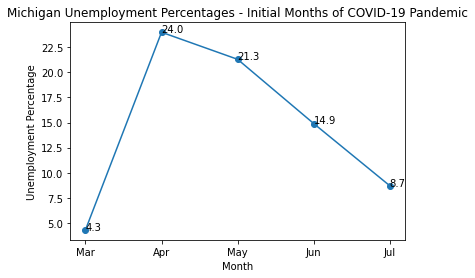

In [46]:
#Visualization 1 - Unemployment in Michigan for March through July
%matplotlib inline

miEmploymentData['Michigan'] = miEmploymentData['Michigan'].apply(pd.to_numeric) 
x = miEmploymentData['Month']
y = miEmploymentData['Michigan']

plt.scatter(x,y, label = 'Unemployment percentages')
plt.plot(x,y)
plt.title("Michigan Unemployment Percentages - Initial Months of COVID-19 Pandemic")
plt.xlabel('Month')
plt.ylabel('Unemployment Percentage')
for i, txt in enumerate(y):
    plt.annotate(txt, (x[i], y[i]))

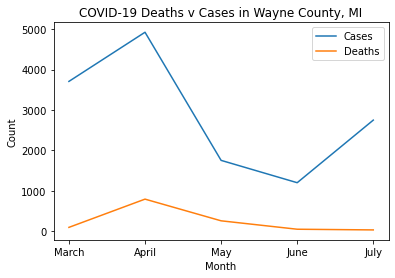

In [47]:
#Visualization 2 - Wayne County, Michigan Daily COVID-19 Cases V Deaths
finalDf['Deaths.Cumulative'] = finalDf['Deaths'].apply(pd.to_numeric)
finalDf['Cases.Cumulative'] = finalDf['Cases'].apply(pd.to_numeric)

#Separate the DF for each month
finalDfMarch = finalDf[finalDf['Month'] == 'Mar'].reset_index()
finalDfApril = finalDf[finalDf['Month'] == 'Apr'].reset_index()
finalDfMay = finalDf[finalDf['Month'] == 'May'].reset_index()
finalDfJune = finalDf[finalDf['Month'] == 'Jun'].reset_index()
finalDfJuly = finalDf[finalDf['Month'] == 'Jul'].reset_index()

yCases = {'March': finalDfMarch['Cases'].sum(), 
          'April':finalDfApril['Cases'].sum(), 
          'May': finalDfMay['Cases'].sum(), 
          'June': finalDfJune['Cases'].sum(), 
          'July': finalDfJuly['Cases'].sum()
         }

yDeaths = {'March': finalDfMarch['Deaths'].sum(), 
          'April': finalDfApril['Deaths'].sum(), 
          'May': finalDfMay['Deaths'].sum(), 
          'June': finalDfJune['Deaths'].sum(), 
          'July': finalDfJuly['Deaths'].sum()
          }

x1 = []
for key in yCases.keys():
    x1.append(str(key))
y1 = []
for count in yCases.values():
    y1.append(int(count))
    
y2 = []
for count in yDeaths.values():
    y2.append(int(count))

plt.plot(x1, y1, label="Cases")
plt.plot(x1, y2, label="Deaths")
plt.title("COVID-19 Deaths v Cases in Wayne County, MI")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend()

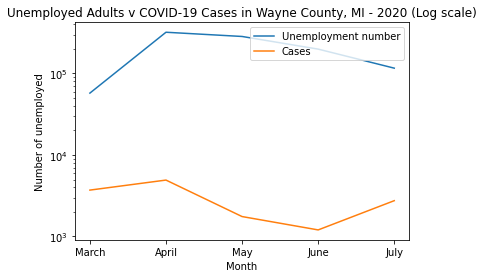

In [48]:
#Visualization 3 - Number of adults in Wayne County, Mi that were unemployed v the number of cases (Log scale) (Makes use of two of the original datasets)
#Current Wayne County, Mi adult population number : 1,336,498 
#Source : https://www.census.gov/quickfacts/waynecountymichigan

yUnemployment = {'March': int((float(finalDfMarch['Michigan'][1])/100.0)*1336498), 
          'April': int((float(finalDfApril['Michigan'][1])/100.0)*1336498), 
          'May': int((float(finalDfMay['Michigan'][1])/100.0)*1336498), 
          'June': int((float(finalDfJune['Michigan'][1])/100.0)*1336498), 
          'July': int((float(finalDfJuly['Michigan'][1])/100.0)*1336498)
         }

y3 = []
for count in yUnemployment.values():
    y3.append(int(count))
plt.plot(x1, y3, label = "Unemployment number")
plt.plot(x1, y1, label = "Cases")
plt.yscale('log')
plt.title('Unemployed Adults v COVID-19 Cases in Wayne County, MI - 2020 (Log scale)')
plt.xlabel("Month")
plt.ylabel("Number of unemployed")
plt.legend(loc='upper right')

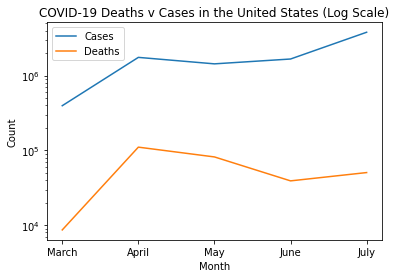

In [49]:
#Visualization 4 - Number of cases v deaths in the United States 
yCasesNational = {'March': finalDfMarch['positiveIncrease'].sum(), 
          'April':finalDfApril['positiveIncrease'].sum(), 
          'May': finalDfMay['positiveIncrease'].sum(), 
          'June': finalDfJune['positiveIncrease'].sum(), 
          'July': finalDfJuly['positiveIncrease'].sum()
         }

yDeathsNational = {'March': finalDfMarch['deathIncrease'].sum(), 
          'April': finalDfApril['deathIncrease'].sum(), 
          'May': finalDfMay['deathIncrease'].sum(), 
          'June': finalDfJune['deathIncrease'].sum(), 
          'July': finalDfJuly['deathIncrease'].sum()
          }

y4 = []
for count in yCasesNational.values():
    y4.append(int(count))
    
y5 = []
for count in yDeathsNational.values():
    y5.append(int(count))

plt.plot(x1, y4, label="Cases")
plt.plot(x1, y5, label="Deaths")
plt.title("COVID-19 Deaths v Cases in the United States (Log Scale)")
plt.xlabel("Month")
plt.ylabel("Count")
plt.yscale('log')
plt.legend()

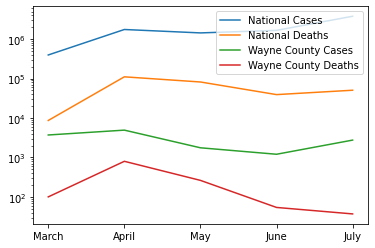

In [50]:
#Visualization 5 - COVID-19 cases and deaths in Wayne County v the United States (Makes use of two of the original datasets)

plt.plot(x1, y4, label="National Cases")
plt.plot(x1, y5, label="National Deaths")
plt.plot(x1, y1, label="Wayne County Cases")
plt.plot(x1, y2, label="Wayne County Deaths")
plt.yscale("log")
plt.legend(loc='upper right')

In [ ]:
#Project Summary
'''
This project was used as a way for me to compare my home county of Wayne County, Michigan and it’s response to the COVID-19 
pandemic against the response of the entire nation. The project originally started out as a way for me to find how the 
pandemic affected both unemployment numbers and violent crime. The Wayne County crime results were difficult to parse 
through and ultimately forced me into the decision of dropping the dataset as I simply didn’t have enough time to learn 
how to work with a geoJSON file. I have since learned that there is a library called geoPandas that operates quite similarly 
to the pandas library, but it works with geo- files. In future classes, I may revisit this. 

After swapping the crime dataset for the national COVID dataset, I was able to work with my data 
much more easily. Some of the things that I learned was how to troubleshoot an API call. I found 
that my API had a few small intricacies that I was not used to. I also learned more about how sqlite works and 
how to communicate with not only in-memory databases, but local databases, like one hosted on your local machine 
through Microsoft SQL server management studio. 

Overall, I think this was a great project that really summed up all aspects of the course. I still am struggling 
with web scrapping, but this project and the previous assignment on it has helped me become at least proficient in the skill. 
'''